# Analyse a specific flood event
***

**Author**: Chus Casado<br>
**Date**: 06-06-2023<br>

**Introduction**:<br>
In this plot we can analyse single flood events by specifying a reporting point and a time period. The analysis is done in three ways:

1. It compares the "observed" (reanalysis) discharge and the forecasted discharge for each numercial weather prediction (NWP) model and forecast.
2. It loads the probability of exceedance computed in other notebooks and shows the forecasted probability for each of the NWP.
3. It load the optimized notification criteria and shows how each of the approached would have performed in the event. A plot shows the total probability of exceedance, how this latter is converted into predicted events when the probability and persistence criteria are applied, and the comparison against the "observed" event.

**Questions**:<br>


**Tasks to do**:<br>

**Interesting links**<br>


In [1]:
import os
path_root = os.getcwd()
import glob
import numpy as np
import pandas as pd
import xarray as xr
from datetime import datetime, timedelta
import time
import pickle
import yaml

os.environ['USE_PYGEOS'] = '0'
import geopandas as gpd

import warnings
warnings.filterwarnings("ignore")

os.chdir('../py/')
from compute import *
from plot.results import *
from plot.maps import create_cmap
from convert import reshape_DataArray
os.chdir(path_root)

## 1 Configuration

In [2]:
with open("../conf/config.yml", "r", encoding='utf8') as ymlfile:
    cfg = yaml.load(ymlfile, Loader=yaml.FullLoader)

### 1.1 Reporting points

In [3]:
stn = 1915
start, end = datetime(2021, 1, 15), datetime(2021, 3, 1)

In [4]:
# area threshold
area_threshold = cfg.get('reporting_points', {}).get('area', 500)

# reporting points
path_stations = cfg.get('paths', {}).get('output', {}).get('reporting_points', '../results/reporting_points/')
file_stations = f'{path_stations}reporting_points_over_{area_threshold}km2.parquet'

### 1.2 Discharge

In [5]:
path_dis_reanalysis = cfg.get('discharge', {}).get('output', {}).get('reanalysis', f'../data/discharge/reanalysis/')
path_dis_forecast = cfg.get('discharge', {}).get('input', {}).get('forecast', f'../data/discharge/forecast/')

### 1.3 Exceedance

In [6]:
path_exc_forecast = cfg.get('exceedance', {}).get('output', {}).get('forecast', f'../data/exceedance/forecast/')

### 1.4 Hits

In [7]:
path_hits = cfg.get('hits', {}).get('output', f'../results/hits/')
path_weights = f'{path_hits}weighing/'

### 1.5 Skill

In [8]:
# current operationa criteria
current_criteria = cfg.get('skill', {}).get('current_criteria', None)

# minimum lead time
min_leadtime = cfg.get('skill', {}).get('leadtime', 60) 

# coefficient of the fbeta-score
beta = cfg.get('skill', {}).get('beta', 1)
metric = f'f{beta}'

# path where results will be saved
path_out = cfg.get('skill', {}).get('output', f'../results/skill/')
for path in [path_out, f'{path_out}{metric}/points/']:
    if os.path.exists(path) is False:
        os.makedirs(path)
        
# best criteria
file_criteria = f'{path_out}/{metric}/best_criteria_2000km2_1424points.pkl'

## 2 Data

### 2.1 Stations 

In [9]:
stations = pd.read_parquet(file_stations)
stations = pd.DataFrame(stations.loc[stn]).transpose()
print('no. stations:\t\t\t{0}'.format(stations.shape[0]))

thresholds = stations[['rl1.5', 'rl2', 'rl5', 'rl20']].squeeze()

title = '{0} - {1} ({2})'.format(stn, *stations.loc[stn, ['name', 'subcatchment']])

no. stations:			1


### 2.2 Discharge 
#### 2.2.1 Reanalysis

In [10]:
# load timeseries of discharge reanalysis
Qobs = xr.open_dataarray(f'{path_dis_reanalysis}{stn:04}.nc').to_pandas()

# observed events
obs = (Qobs > thresholds.rl5).astype(int).loc[start + timedelta(days=10):end]
print('no. observed events:\t{0}'.format((np.diff(obs) == 1).sum()))
obs = xr.DataArray(obs, coords={'datetime': obs.index})

no. observed events:	0


In [11]:
ymax = thresholds.rl20 * 2.5 #60

fig, ax = plt.subplots(figsize=(16, 4))
ax.plot(Qobs.index, Qobs, c='k', lw=.8, zorder=5)
if thresholds is not None:
    ax.fill_between(pd.date_range(start, end), thresholds['rl1.5'], thresholds['rl2'], color='green', edgecolor=None, alpha=.1, zorder=0, label='1.5-year')
    ax.fill_between(pd.date_range(start, end), thresholds['rl2'], thresholds['rl5'], color='yellow', edgecolor=None, alpha=.1, zorder=0, label='2-year')
    ax.fill_between(pd.date_range(start, end), thresholds['rl5'], thresholds['rl20'], color='red', edgecolor=None, alpha=.1, zorder=0, label='5-year')
    ax.fill_between(pd.date_range(start, end), thresholds['rl20'], ymax, color='mediumpurple', edgecolor=None, alpha=.1, zorder=0, label='20-year')
ax.set(xlim=(start, end), ylim=(0, ymax), ylabel='Q (m3/s)');

#### 2.2.2 Discharge forecast

**List available data**

In [12]:
# list files
fore_files = {model: [] for model in models}
for year in np.arange(start.year, end.year + 1):
    for month in range(1, 13):    
        # list files
        for model in models:
            fore_files[model] += glob.glob(f'{path_dis_forecast}{model}/{year}/{month:02d}/*.nc')

# count files and check if all are avaible
n_files = pd.Series(data=[len(fore_files[model]) for model in models], index=models)

# list of forecast from the beginning to the end of the data
for model in models:
    st, en = [datetime.strptime(fore_files[model][step][-13:-3], '%Y%m%d%H') for step in [0, -1]]
    start = max(st, start)
    end = min(en, end)
dates = pd.date_range(start, end, freq='12h')

# find missing files
if any(n_files != len(dates)):
    missing = {}
    for model in models:
        filedates = [datetime.strptime(file[-13:-3], '%Y%m%d%H') for file in fore_files[model]]    
        missing[model] = [date for date in dates if date not in filedates]
    print('mising files:', missing)

# trim files to the period where all models are available
for model in models:
    fore_files[model] = [file for file in fore_files[model] if start <= datetime.strptime(file[-13:-3], '%Y%m%d%H') <= end]
    print('{0}:\t{1} files'.format(model, len(fore_files[model])))

mising files: {'COS': [], 'DWD': [], 'EUD': [], 'EUE': []}
COS:	91 files
DWD:	91 files
EUD:	91 files
EUE:	91 files


### 2.3 Exceedance

In [13]:
# load data
exceedance = xr.open_dataset(f'{path_exc_forecast}{stn:>04d}.nc')
exceedance = exceedance.sel(forecast=slice(start, end))
if 'high' in list(exceedance):
    exceedance = exceedance['high']
exceedance = reshape_DataArray(exceedance)
exceedance = exceedance.sel(datetime=slice(start + timedelta(days=10), end))

### 2.4 Skill

In [14]:
# import optimized notification criteria
file = open(file_criteria, 'rb')
criteria = pickle.load(file)

# import weighting factors based on the number of members
weights_member = xr.open_dataarray(f'{path_weights}weights_member.nc')

# import weighting factors based on the Brier score
weights_brier = xr.open_dataarray(f'{path_weights}weights_brier.nc')

## 3. Analysis

### 3.1 Discharge

COS	E:/casadje/Documents/skill_assessment/data/CDS/forecast/COS/2021/03\COS2021030100.nc
DWD	E:/casadje/Documents/skill_assessment/data/CDS/forecast/DWD/2021/03\DWD2021030100.nc
EUD	E:/casadje/Documents/skill_assessment/data/CDS/forecast/EUD/2021/03\EUD2021030100.nc
EUE	E:/casadje/Documents/skill_assessment/data/CDS/forecast/EUE/2021/03\EUE2021030100.nc


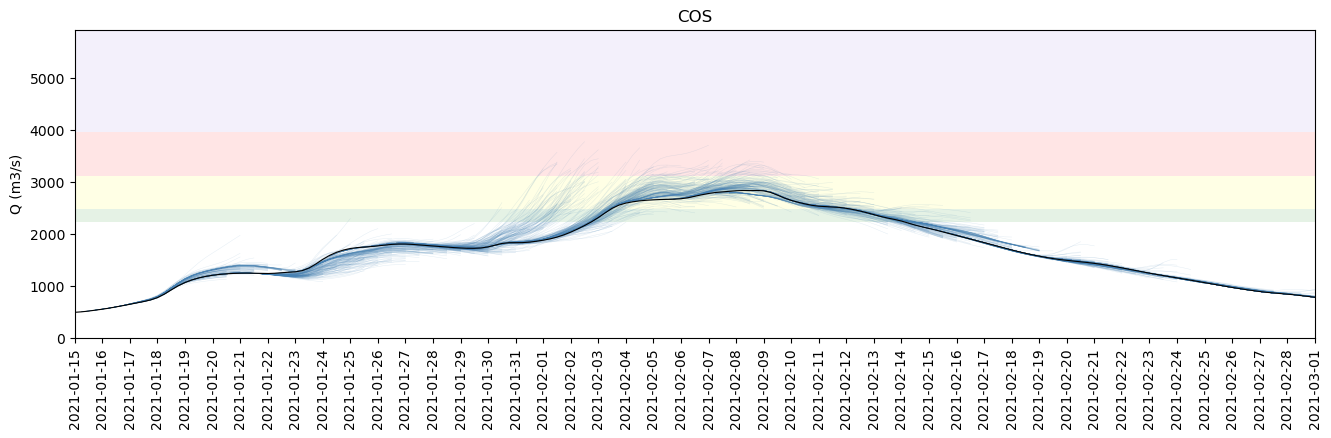

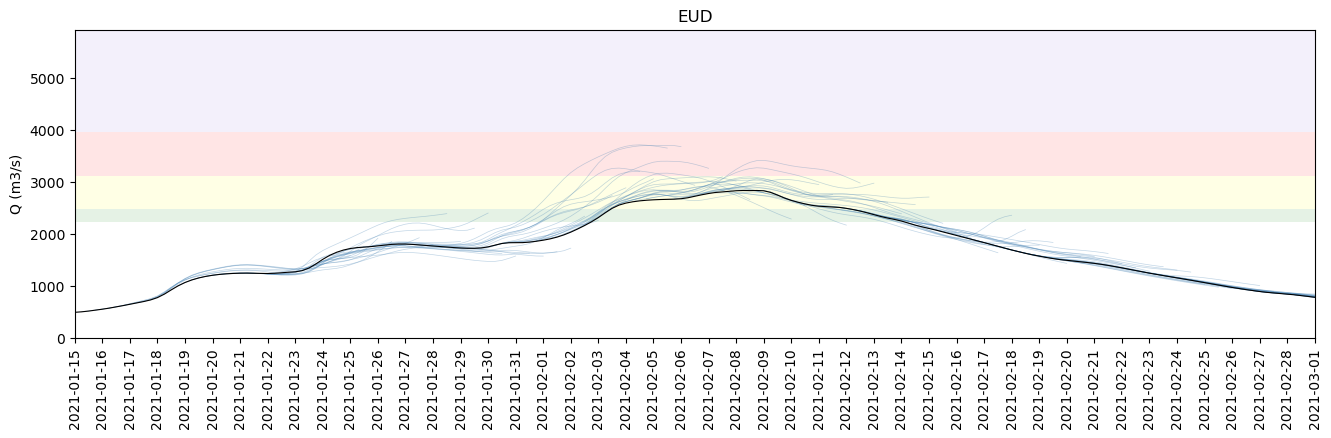

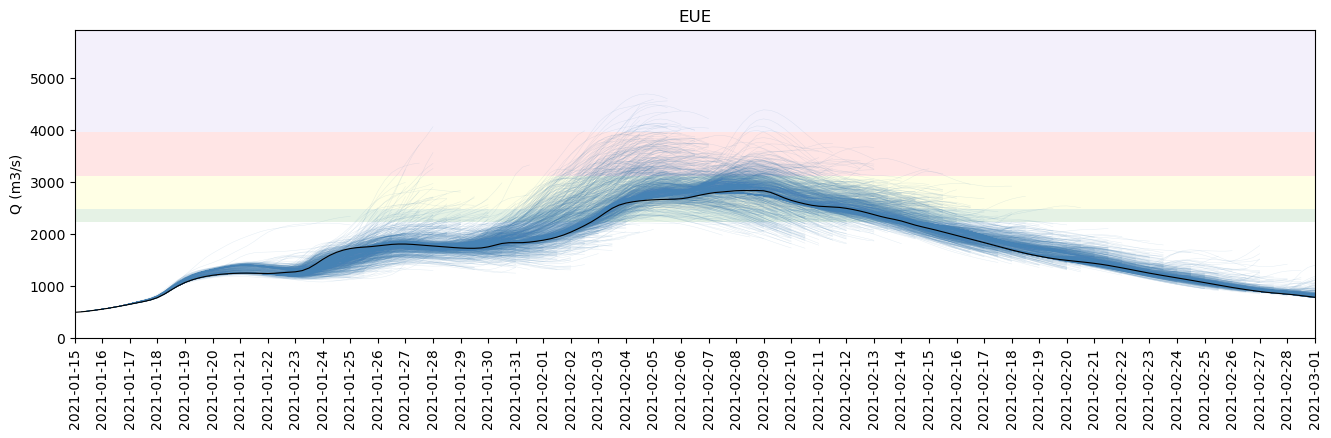

In [15]:
ymax = thresholds.rl20 * 1.5

for model in models:

    fig, ax = plt.subplots(figsize=(16, 4))

    for file in fore_files[model]:

        print(f'{model}\t{file}', end='\r')

        # open dataaray with dicharge data
        dis = xr.open_dataarray(file).isel(time=slice(1, None))
        dis['time'] = dis.time - np.timedelta64(6, 'h')
        # limit the forecast to its maximum leadtime
        if len(dis.time) > models[model]['leadtimes']:
            dis = dis.isel(time=slice(None, models[model]['leadtimes']))

        dis_stn = dis.sel(stations=str(stn))

        if 'member' in dis_stn.dims:
            for member in dis_stn.member.data:
                ax.plot(dis_stn.time, dis_stn.sel(member=member), c='steelblue', lw=.33, alpha=.15)
        else:
            ax.plot(dis_stn.time, dis_stn, c='steelblue', lw=.5, alpha=.33)

    ax.plot(Qobs.index, Qobs, c='k', lw=.8, zorder=5)

    ax.set(xlim=(start + timedelta(days=10), end), ylim=(0, ymax), ylabel='Q (m3/s)')
    xticks = pd.date_range(start, end, freq='d').date
    ax.set_xticks(xticks, labels=xticks, rotation=90)
    # ax.grid(True)

    if thresholds is not None:
        ax.fill_between(pd.date_range(start, end), thresholds['rl1.5'], thresholds['rl2'], color='green', edgecolor=None, alpha=.1, zorder=0, label='1.5-year')
        ax.fill_between(pd.date_range(start, end), thresholds['rl2'], thresholds['rl5'], color='yellow', edgecolor=None, alpha=.1, zorder=0, label='2-year')
        ax.fill_between(pd.date_range(start, end), thresholds['rl5'], thresholds['rl20'], color='red', edgecolor=None, alpha=.1, zorder=0, label='5-year')
        ax.fill_between(pd.date_range(start, end), thresholds['rl20'], ymax, color='mediumpurple', edgecolor=None, alpha=.1, zorder=0, label='20-year')

    ax.set_title(model);

    plt.savefig(f'{path_out}{metric}/points/{stn:>04}_{start:%Y%m%d}_{end:%Y%m%d}_{model}.jpg', dpi=300, bbox_inches='tight')
    
    print()

### 3.2 Exceendance probability

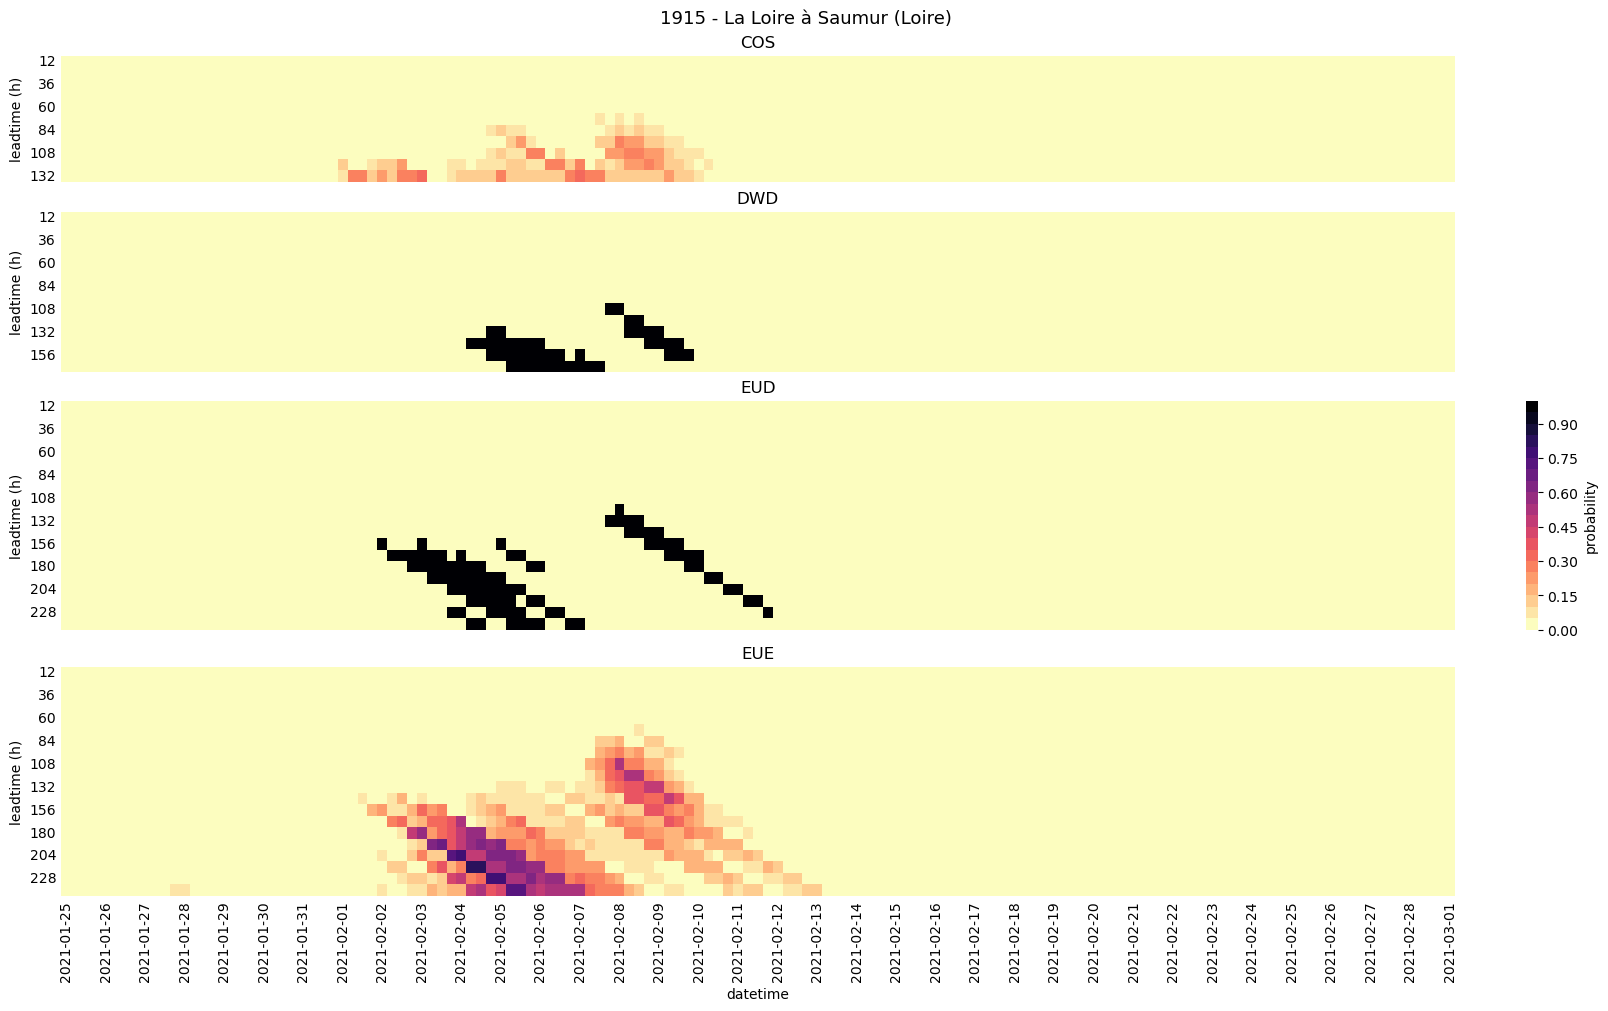

In [16]:
cmap_p, norm_p = create_cmap('magma_r', np.arange(0, 1.01, .05))

fig = plt.figure(figsize=(16, 10), constrained_layout=True)
height_ratios = [int(dct['leadtimes'] / 2) for label, dct in models.items()]
gs = fig.add_gridspec(nrows=len(height_ratios), height_ratios=height_ratios)

for i, (label, dct) in enumerate(models.items()):
    ax = fig.add_subplot(gs[i])
    if i + 1 < len(height_ratios):
        xticklabels, xlabel = [], None
    else:
        xticklabels, xlabel = exceedance.datetime.data, 'datetime'
    ylabel = 'leadtime (h)'
    if i == 2:
        cbar = True
    else:
        cbar = False
    plot_DataArray(exceedance.sel(model=label).isel(leadtime=slice(0, int(models[label]['leadtimes'] / 2))),
                   xtick_step=4, ytick_step=2, cbar=cbar, cbar_kws={'label': 'probability'}, title=label, xticklabels=xticklabels, xlabel=xlabel,
                   ylabel=ylabel, ax=ax, cmap=cmap_p, norm=norm_p)
    
fig.suptitle(title, fontsize=13);

plt.savefig(f'{path_out}{metric}/points/{stn:>04}_{start:%Y%m%d}_{end:%Y%m%d}_exceedance_probability.jpg', dpi=300, bbox_inches='tight')

### 3.3 Hits, misses and false alarms

#### 3.3.1 1 deterministic & 1 probabilistic

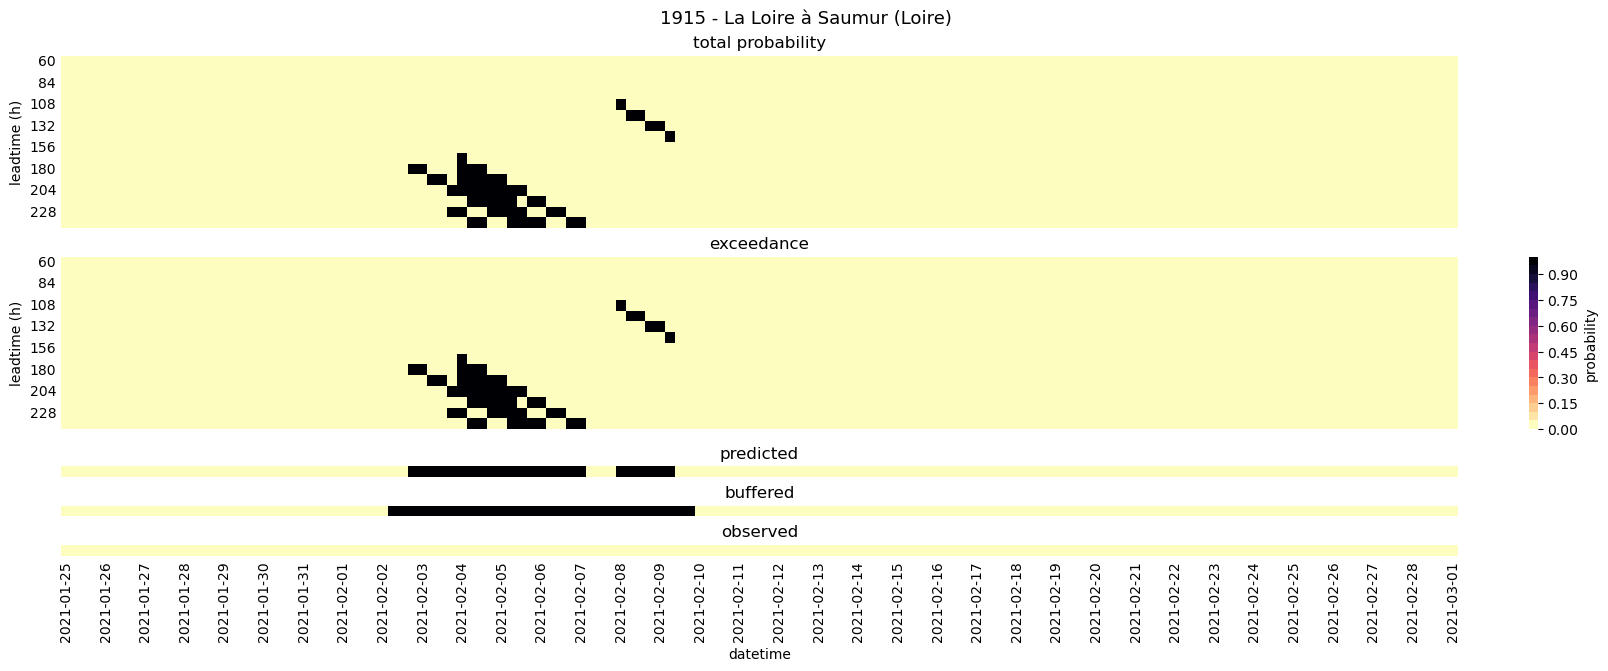

In [17]:
# extract best criteria
approach = '1_deterministic_+_1_probabilistic'
probability = float(criteria[approach]['probability'])
persistence = [int(x) for x in str(criteria[approach]['persistence']).split('/')]

# exceedance according to current criteria
deterministic = (exceedance.sel(model=['EUD', 'DWD']) >= probability).any('model')
probabilistic = (exceedance.sel(model=['EUE', 'COS']) >= probability).any('model')
current = (deterministic & probabilistic).sel(leadtime=slice(min_leadtime, None))

plot_prediction(current, obs, probability, persistence, min_leadtime,
                cmap=cmap_p, norm=norm_p, title=title,
                save=f'{path_out}{metric}/points/{stn:>04}_{start:%Y%m%d}_{end:%Y%m%d}_current.jpg')

#### 3.3.2 Model mean

In [18]:
# extract best criteria
approach = 'model_mean'
probability = float(criteria[approach]['probability'])
persistence = [int(x) for x in str(criteria[approach]['persistence']).split('/')]

# exceedance according to mean over models
model_mean = exceedance.mean('model', skipna=True).sel(leadtime=slice(min_leadtime, None))

plot_prediction(model_mean, obs, probability, persistence, min_leadtime,
                cmap=cmap_p, norm=norm_p, title=title,
                save=f'{path_out}{metric}/points/{stn:>04}_{start:%Y%m%d}_{end:%Y%m%d}_model_mean.jpg')

#### 3.3.3 Weighted by no. members

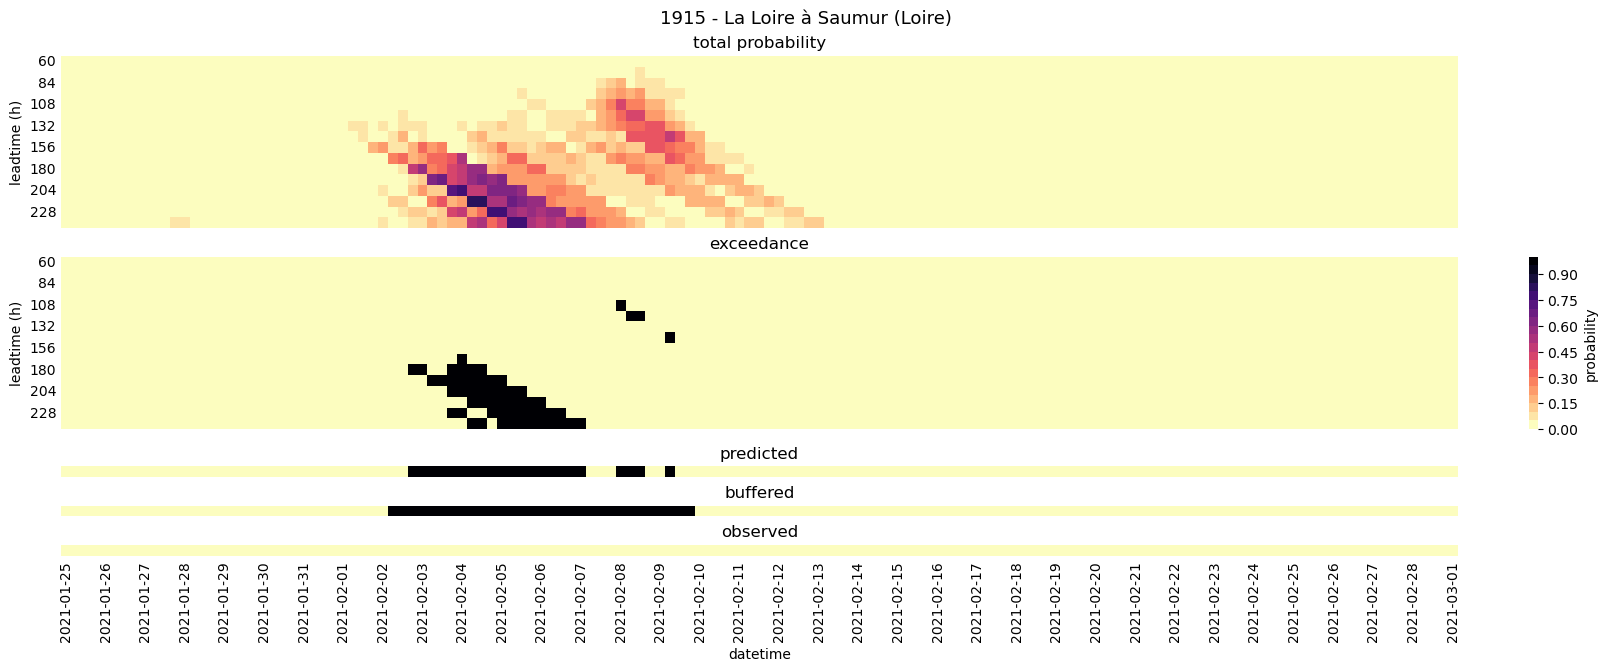

In [19]:
# extract criteria
approach = 'member_weighted'
probability = float(criteria[approach]['probability'])
persistence = [int(x) for x in str(criteria[approach]['persistence']).split('/')]

# exceedance according to the mean over models weighted by the number of members
member_weighted = exceedance.weighted(weights_member.fillna(0)).mean('model', skipna=True).sel(leadtime=slice(min_leadtime, None))

plot_prediction(member_weighted, obs, probability, persistence, min_leadtime,
                cmap=cmap_p, norm=norm_p, title=title,
                save=f'{path_out}{metric}/points/{stn:>04}_{start:%Y%m%d}_{end:%Y%m%d}_member_weighted.jpg')

#### 3.3.4 Weighted by performance

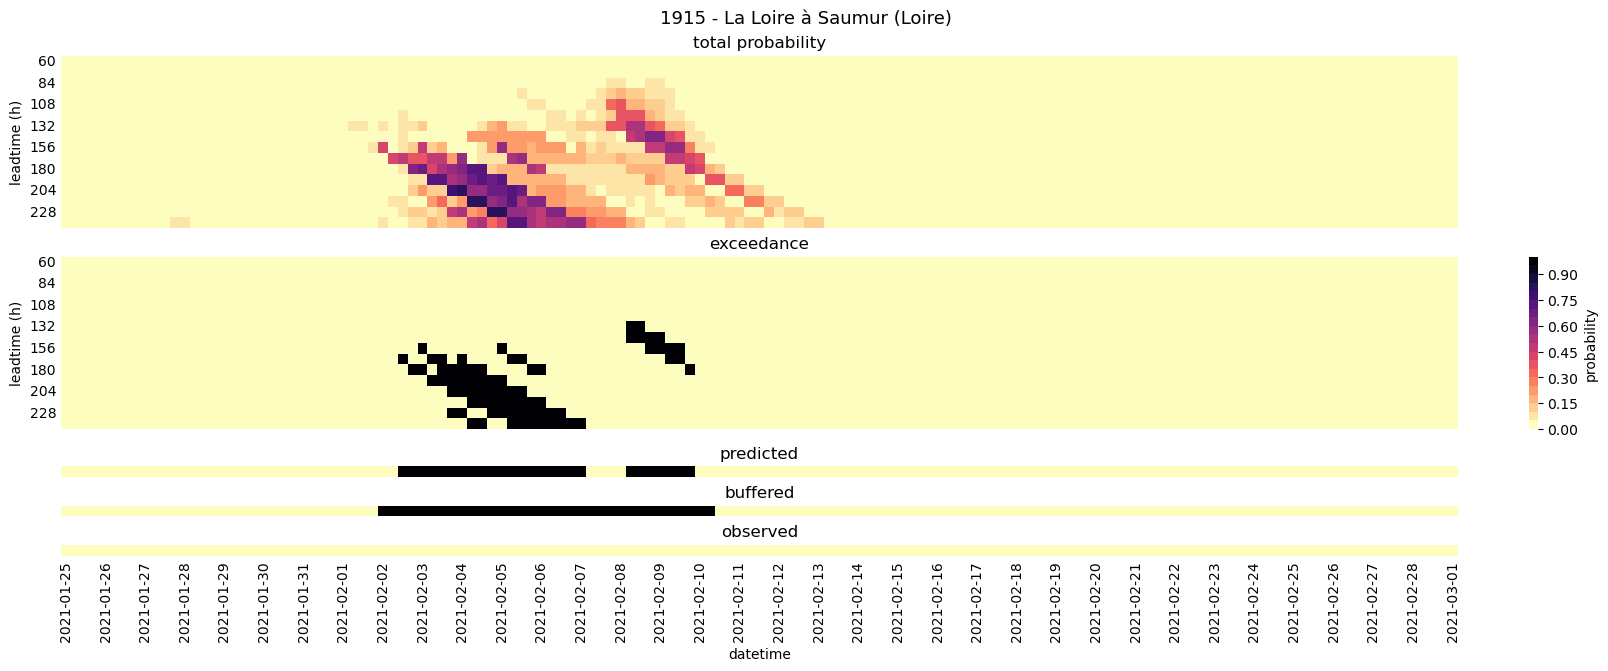

In [20]:
# extract criteria
approach = 'brier_weighted'
probability = float(criteria[approach]['probability'])
persistence = [int(x) for x in str(criteria[approach]['persistence']).split('/')]

# exceedance according to the mean over models weighted by the number of members
brier_weighted = exceedance.weighted(weights_brier.fillna(0)).mean('model', skipna=True).sel(leadtime=slice(min_leadtime, None))

plot_prediction(brier_weighted, obs, probability, persistence, min_leadtime,
                cmap=cmap_p, norm=norm_p, title=title,
                save=f'{path_out}{metric}/points/{stn:>04}_{start:%Y%m%d}_{end:%Y%m%d}_brier_weighted.jpg')